# `mhn` Demonstration

In this notebook, we will demonstrate a basic workflow for using the `mhn` python package. As exemplary data, we use somatic mutations in 12 driver genes of lung cancer patients. A similar analysis has been conducted on the same dataset in the publication __[Overcoming Observation Bias for Cancer Progression Modeling](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__ and was originally obtained through __[AACR GENIE](https://doi.org/10.7303/syn51355584)__. 

In the following sections, we will
1. [Check the necessary installations](#confirming-package-functionality)
2. [Load and inspect input data](#loading-and-inspecting-input-data)
3. [Prepare for MHN training](#preparation-for-mhn-training)
    1. [Choose a penalty](#choosing-the-regularization-penalty)
    2. [Prepare for cross-validation](#choosing-the-regularization-penalty)
    3. [Choose a processing device](#choosing-the-processing-device)
4. [Execute MHN training with cross-validation](#executing-mhn-training)
    1. [Perform cross-validation](#cross-validation)
    2. [Train the final models](#final-model-training)
5. [Inspect the primary MHN output - the Θ-matrix](#inspecting-the-θ-matrix)
6. [Reconstruct event orders](#reconstructing-event-orders)
7. [Simulate artifical data from the trained models...](#simulating-artificial-data-from-a-mhn)
8. [Make next-event predictions using MHN inferences](#predicting-the-next-event-for-a-given-mhn-state)

## Confirming package functionality

This notebook assumes that the package has been installed via `pip install mhn`. We can confirm the functionality of the installation with

In [172]:
try:
    import mhn
    print("mhn is installed")
except ImportError:
    print("mhn installation not found")

mhn is installed


We can now make all MHN imports necessary for this notebook:

In [173]:
from mhn.optimizers import Optimizer, Device

If available, a Nvidia GPU may be used to accelerate MHN training. Apart from the GPU itself, this requires a functional installation of __[CUDA and the CUDA compiler nvcc](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/)__. This approach is optional and will be treated as such in the notebook. 
We can check if CUDA is available to MHN with

In [174]:
cuda_status = mhn.cuda_available()
print(cuda_status)

CUDA compiler nvcc was not present during installation


## Inspecting and loading input data

We now import the lung adenocarcinoma dataset. MHN expects a binary matrix (containing only 0s and 1s), with rows representing individual observations (e.g., patients/tumors), columns representing individual events (e.g., per-gene mutations) and cells representing the presence or absence (1s or 0s) of the respective event in the respective observation. Event identifiers may be given as column names. To inspect the input data, we can load it with

In [175]:
import pandas as pd
input = pd.read_csv('LUAD_n12.csv')
input.head()

,TP53,KRAS,EGFR,STK11,RBM10,KEAP1,ATM,SMARCA4,PTPRD,NF1,PIK3CA,BRAF
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,0,0,0


Let us now inspect some basic data stats

In [176]:
print("Number of observations:", len(input))
print("Number of events:", len(input.columns))

Number of observations: 3662
Number of events: 12


In [177]:
print("Event frequencies:")
input.sum(axis=0) / len(input)

Event frequencies:


TP53       0.410705
KRAS       0.341344
EGFR       0.279902
STK11      0.141999
RBM10      0.118788
KEAP1      0.103768
ATM        0.059803
SMARCA4    0.058711
PTPRD      0.057619
NF1        0.057073
PIK3CA     0.049153
BRAF       0.048334
dtype: float64

In [178]:
print("Distribution of active event counts across observations:")
input.sum(axis=1).value_counts().sort_index()

Distribution of active event counts across observations:


0     477
1    1086
2    1327
3     550
4     180
5      37
6       5
Name: count, dtype: int64

The dataset is a little large to be used completely in this notebook, so let's only take a part of the data:

In [179]:
import random
input_subset = input.sample(n=500, random_state=6)
input_subset.sum(axis=1).value_counts().sort_index()

0     72
1    137
2    186
3     68
4     27
5     10
Name: count, dtype: int64

## Preparation for MHN training

In preparation for MHN training, one has to make a few decisions regarding the model framework and cross-validation strategies. We will now guide through these decisions step by step. Afterwards, the actual training process, including cross-validation, will be two simple lines of code.

We will show the training of an observation-aware MHN as discussed in __[Schill et al. 2024](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__.

In [180]:
opt = Optimizer()

Once we have initialised the optimizer object, we can give it the input dataframe:

In [181]:
# load data for the oMHN framework
opt.load_data_matrix(input_subset)

Alternatively, we could have used the `load_data_from_csv()` function to load the input data directly from a .csv.

### Choosing the regularization penalty

Like most machine learning models, MHN uses regularization during the training process. In brief, regularization means penalising the parameter inference so that a sparse (parsimonious) set of parameters is generally preferred. In other words, it aims at explaining the training input data well, with as little parameters as possible, to keep the model generalisable to test data. While the *strength* of the regularization penalty is determined later during cross-validation, we now have to decide on the *form* of regularization. <br><br>
There are two forms of penalty currently implemented for MHN, a **standard L1-penalty** and a **custom symmetrical penalty**. The L1-penalty is a standard approach in machine learning and keeps each parameter uniformly close to 0. In contrast, the symmetrical penalty restricts pairs of parameters simultaneously, specifically pairs which are symmetrical in Θ with respect to the diagonal. Having one such pair of parameters at a nonzero value is as costly as having only one of them at the same value. This is further discussed in __[Schill et al. 2024](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__. **We recommend to choose the penalty based on prior knowledge about the structure of effects that are expected in the type of data one is working with. For mutational data as in this notebook, we recommend the symmetrical penalty as it is likely more in line with the nature of epistatic effects between driver mutations.**
Note that both penalties **do not include the base rates**, i.e., the parameters on the diagonal of the parameter matrix will not be regularized at all.<br><br>
In terms of code, this decision is made by calling the respective penalty-setting function. In our example, we set the symmetrical penalty:

In [182]:
opt.set_penalty(opt.Penalty.SYM_SPARSE)

### Choosing cross-validation hyperparameters

In cross-validation, a range of different regularization penalty strengths ("lambdas") will be tested to identify one which yields optimal performance on holdout data. Here, we have to decide on some hyperparameters:
- The minimum and maximum penalty strength ("lambda") to be tested
- The amount of steps (i.e., length of the lambda sequence) to take between these limits
- The amount of folds we want to split our data into for cross-validation

Generally, a large range with small step size and many folds will yield the most accurate results while increasing computation time. For the purpose of this demonstration however, we will pick values that are easy on the computation. 

Generally, one can expect that 1 divided by the number of observations will yield a decent cross-validation result, so we can design our minimum and maximum values around it:

In [183]:
lambda_min = 0.1/len(input_subset)
lambda_max = 100/len(input_subset)

print("Minimum lambda:", lambda_min)
print("Maximum lambda:", lambda_max)

Minimum lambda: 0.0002
Maximum lambda: 0.2


The more steps in between min/max, the more accuate the cross-validation will be within the given limits. However, here we pick a small amount to keep computation time low:

In [184]:
n_cv_steps = 5

When provided with min/max values and a number of steps, MHN's cross-validation will run with the respective number of intermediate lambda values, spaced equidistantly on a log scale. Alternatively, one specify all values, including intermediate steps. For the purpose of this demonstration, we will explicitely specify the full range albeit using default MHN behavior: 

In [185]:
import numpy as np

lambda_sequence = np.exp(np.linspace(
    np.log(lambda_min + 1e-10), np.log(lambda_max + 1e-10), n_cv_steps))

print("Lambda sequence:")
lambda_sequence

Lambda sequence:


array([0.0002    , 0.00112468, 0.00632456, 0.03556559, 0.2       ])

Lastly, we have to define the number of cross-validation folds. For this demonstration, we will just do 3 folds:

In [186]:
n_cv_folds = 3

### Choosing the processing device

As the last step before training, we have to make a purely technical decision: If our device has a Nvidia GPU and CUDA is installed, we can opt to perform (some of) the intensive computing on the GPU. This may yield significant speedup, especially of our input matrix is densely populated with 1s. If our device does not have this capability, we can simply use the CPU instead. The default behavior of MHN is to use the GPU only for parts of the data where it is likely beneficial. <br><br>

To ensure accessibility, we will opt for CPU-only in this demonstration:

In [187]:
# uses both CPU and GPU depending on the number of mutations in the individual sample (default)
# opt.set_device(Device.AUTO)

# use the GPU to compute log-likelihood score and gradient
# opt.set_device(Device.GPU)

# use the CPU to compute log-likelihood score and gradient
opt.set_device(Device.CPU)

## Executing MHN training

### Cross-validation
Once our preparation is done, we can call the `lambda_from_cv()` function to perform the cross-validation, providing the previously set parameters. To reiterate, we have the option of either providing an explicit sequence of lambdas or defining min, max and a number of steps. Furthermore, we specify the number of cross-validation folds and whether we want a progress tracker:

In [188]:
np.random.seed(6)
opt_lam, lambda_scores = opt.lambda_from_cv(
    lambda_min=lambda_min, lambda_max=lambda_max, steps=n_cv_steps, nfolds=n_cv_folds, show_progressbar=True, return_lambda_scores=True)

Cross-Validation Folds: 100%|██████████| 3/3 [00:22<00:00,  7.66s/it]


When cross-validation has finished, let's see where in the given sequence our optimal lambdas are located (having them at the extremes may indicate that the sequence needs to be adjusted):

Text(0, 0.5, 'mean log-likelihood')

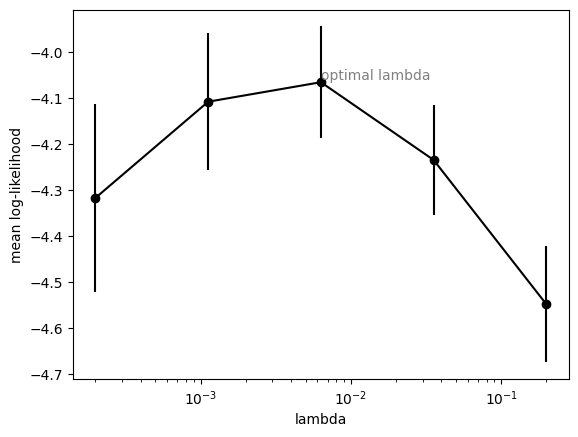

In [189]:
import matplotlib.pyplot as plt

# plot cross-validated lambdas
plt.scatter(lambda_scores["Lambda Value"],
            lambda_scores["Mean Score"], color='black')
plt.errorbar(lambda_scores["Lambda Value"], lambda_scores["Mean Score"],
             yerr=lambda_scores["Standard Error"], color='black')

# annotate optimal lambda
plt.text(opt_lam, lambda_scores[lambda_scores["Lambda Value"] ==
                                    opt_lam]["Mean Score"].values[0], "optimal lambda", va='bottom', ha='left', color="grey", )

# log scale
plt.xscale('log')
# plt.yticks([])
plt.xlabel('lambda')
plt.ylabel('mean log-likelihood')

### Final model training

We can now train the final models, using the optimal lambdas from cross-validation we have just confirmed. Then, we'll save the main output, the Θ-matrix, as .csv file, alongside a log file in .json format.

In [190]:
# train oMHN
opt.train(lam=opt_lam)
# save output
opt.result.save(filename="MHN.csv")

Let's inspect the outputs. First, let's look at the log files which tell us about important technical details of the training process:

In [191]:
import json
import pprint

with open('MHN_meta.json') as f:
    MHN_log = json.load(f)

pprint.pprint(MHN_log)

{'init': None,
 'lambda': 0.006324556903056528,
 'maxit': 5000,
 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'nit': 146,
 'reltol': 1e-07,
 'score': 4.081817807465798,
 'status': 0}


Let's go through these one by one:
- `'init'` tells us about the initial state of Θ at the start of training. By default (`'init': None`), MHN initializes training with the "independence model" - in which the diagonal entries of Θ are set to the empirical odds and the rest of Θ is empty. Alternatively, users have the option to specify some prior parameterization of Θ using the `set_init_theta()` function.
- `'lambda'` shows us the input regularization strength we previously determined through CV.
- `'maxit'` is the specified maximum number of gradient steps before the training is automatically terminated (default: 5000). 
- `'message'` - is the termination message obtained internally from `scipy.optimize.minimize()`. `CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH` is the expected value, which means that the optimization terminated successfully due to parameter convergence. In case other values pop up here, the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) should be consulted. 
- `'nit'` tells us about the number of gradient steps taken before termination.
- `'reltol'` informs us about the input upper bound for parameter changes that are still considered as converged, see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs). This parameter can be changed from default (`1e-07`) in the `train()` function but we advise inexperienced users not to do so. 
- `'score'` informs us about the input data likelihood under the final model. Specifically, it shows the negative logarithm of the sum of likelihoods over all observations (to be minimized during training - the lower, the better). 
- `'status'` is the termination status of the optimizer. Refer to the [documentation of the scipy `OptimizeResult`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) for more information.

## Inspecting the Θ-matrix

To visualise the main MHN output which details all inferred parameters (i.e., event accumulation rates and rate changes between events), we can simply call `plot()`:

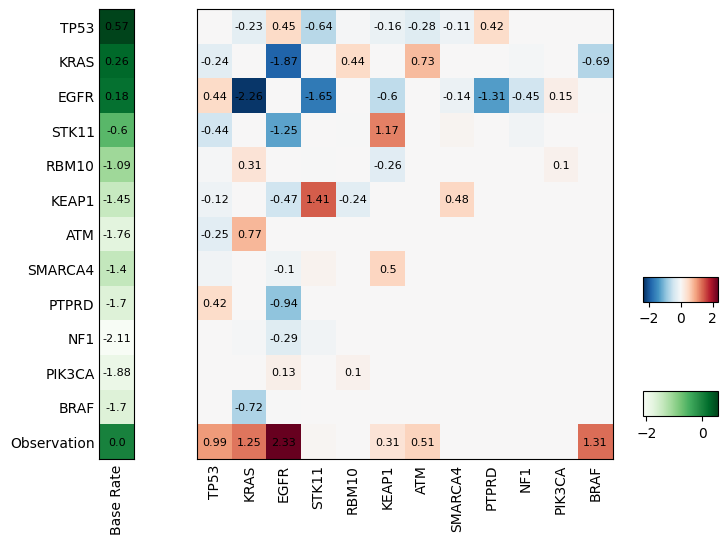

In [192]:
_ = opt.result.plot()

By default, `plot()` visualizes the logarithmised form of Θ - this can be changed with `logarithmic = False`. The logarithmic version is also written to file by `save()`. <br><br>

The base rates of the events are shown on the left in green.

TODO: The matrix on the right in blue and green shows effects between events:
A cell in row x and column y shows the (logarithmized) multiplicative effect that presence of event y has on the rate of event x. For example, presence of STK11 increases the rate of KEAP to `e^1.41 = 4.09 = 409%`. Conversely, presence of BRAF decreases the rate of KRAS to `e^-0.69 = 0.50 = 50%`.

The bottom row shows the effects on the observation event. For example, presence of TP53 increases the rate of observing the given cancer to `e^0.99 = 2.69 = 269%`. 

## Reconstructing event orders

Based on the learnt paramters, an MHN can "reconstruct tumor histories". This means that, for a given set of patient vectors, it can estimate the most probable order in which the patients' events accumulated.

For getting these estimates for our input dataset, we use the `plot_order_tree` function.

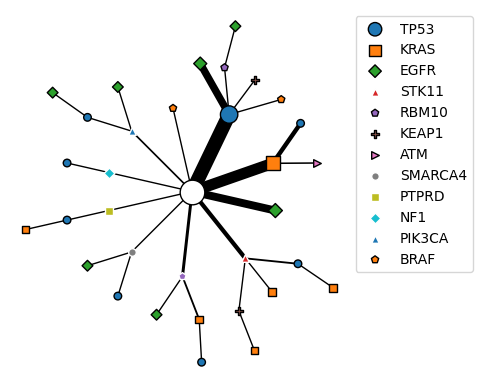

In [198]:
opt.result.plot_order_tree(states=input_subset.to_numpy())
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

This plot shows all inferred orders of the whole input dataset. All trajectories start at the white circle in the middle. Going outwards, events (encoded by the colorful shapes) are accumulated. The edges of the tree scale by the number of patients that took that path. 

For example, we see that there were some patients that only have EGFR. Some patients started with TP53 and subsequently got EGFR. None of the patients in the input dataset got KEAP1 first.

## Simulating artificial data from a MHN

Now, let us use the trained MHN to generate artificial data, both with and without keeping track of the event order.

Let's start with unordered simulations. The output is a binary matrix, just like the data that we trained the MHN on.

In [208]:
# simulate 500 samples for MHN
np.random.seed(6)
sim_observations = opt.result.sample_artificial_data(
    500, as_dataframe=True)
print("oMHN simulations:")
sim_observations.head()

oMHN simulations:


,TP53,KRAS,EGFR,STK11,RBM10,KEAP1,ATM,SMARCA4,PTPRD,NF1,PIK3CA,BRAF
0,1,1,0,1,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0


Next, let's simulate some ordered data. With this, we can for example assess the probability of observing a certain event A before another event B.

To answer this question, we simply
1. Simulate ordered observations
2. Condition the output to those who have both A and B
3. Under the condition, calculate the fraction of trajectories where A preceded B

In [209]:
np.random.seed(6)

# simulate from cMHN
trajectories, times = opt.result.sample_trajectories(
    100000, [], output_event_names=True)

# condition on trajectories which contain KRAS and TP53
indices = np.array([i for i, trajectory in enumerate(
    trajectories) if 'EGFR' in trajectory and 'TP53' in trajectory])
conditioned_trajectories = [trajectories[index] for index in indices]

# of those, count in how many KRAS preceded TP53 and then get the fraction
count_EGFR_first = sum(trajectory.index('EGFR') < trajectory.index(
    'TP53') for trajectory in conditioned_trajectories)
fraction_EGFR_first = count_EGFR_first / len(conditioned_trajectories)

print("MHN: simulation-derived P(EGFR before TP53 | EGFR, TP53 present):",
      fraction_EGFR_first)

MHN: simulation-derived P(EGFR before TP53 | EGFR, TP53 present): 0.32614357805632427


We can see that MHN samples trajectories where either KRAS or TP53 can come first. However, it suggests that TP53 tends to come first.

## Predicting the next event for a given MHN state

In principle, MHNs are capable of estimating the future progression of any state represented by a given MHN. For instance, simulations with non-empty starting states could be used. Additionally, we have implemented a convenience function that, for a given state, returns the probabilities for all possible next events. <br> <br>

To predict the next event for a state that already has KRAS and STK11, we'll give the function an array which is all zeroes apart from the respective columns. Let's check which indices we need:

In [196]:
print(input_subset.columns)

Index(['TP53', 'KRAS', 'EGFR', 'STK11', 'RBM10', 'KEAP1', 'ATM', 'SMARCA4',
       'PTPRD', 'NF1', 'PIK3CA', 'BRAF'],
      dtype='object')


We need the second and fourth entry to be 1, all others be 0. The function can output a simple array, or a dataframe that also contains event names (controlled with `as_dataframe=True`). Further, we can treat the state as unobserved, so that observation itself is also a legitimate next event (controlled with `allow_observation=True`)

In [197]:
# specify state of interest
state_of_interest = np.array(
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.int32)

# get the cMHN predictions, this time with possible observation
predictions = opt.result.compute_next_event_probs(
    state_of_interest, as_dataframe=True, allow_observation=True)

# show
print("next event predictions:")
print(predictions)

next event predictions:
                PROBS
TP53         0.105461
KRAS         0.000000
EGFR         0.003416
STK11        0.000000
RBM10        0.064608
KEAP1        0.136775
ATM          0.052897
SMARCA4      0.038797
PTPRD        0.026006
NF1          0.015307
PIK3CA       0.021722
BRAF         0.012659
Observation  0.522351


We can see that MHN favors KEAP1 as possible next event, although it is generally quite rare. This is because it learned a positive interaction between STK11 and KEAP1. TP53 is the next most likely event (excluding observation). EGFR is estimated as unlikely to follow, although it is generally quite frequent. This is because the model learned a negative interaction between KRAS and EGFR. 